# Susie finemapping analysis

In [1]:
setwd("~/project-gandalm/isoform_twas/eqtl_new/results/susie_finemap")
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))

## Results summary
- We started with 10203 (to be updated) eGenes identified by FastQTL permutation pass for mixed ancestries with 90 HCP in covariates
- After filtering for CS purity: 
    - 7626 genes have non-low purity CS
    - 10647 unique CS
    - 122,203 unique variants in CS
- Of the 10647 CS:
    - 2420 contain exactly one SNP (strong candidates for causal variants)
    - 1288 contain exactly two SNPs
    - median size 5
- Of the 7626 genes:
    - 5486 have exactly one CS

### 1. all variants that belong to a non-low purity credible set

In [2]:
var_in_cs <- fread("mixed_ciseqtl_90hcp_perm.txt.gz", data.table = F)
dim(var_in_cs)

[1] 167292     17

In [4]:
head(var_in_cs)

,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000270863,chr12_11147188_G_A,12,11147188,G,A,ENSG00000270863_L2,L2,chr12:10665656-12665656,0.073696934,4.045431,0.4323245,0.7465146,12,0.023103775,0.08372073,4.263458
2,ENSG00000270863,chr12_11155747_A_G,12,11155747,A,G,ENSG00000270863_L2,L2,chr12:10665656-12665656,0.017965122,3.923467,0.4323245,0.7465146,12,0.005269309,0.04067465,4.263458
3,ENSG00000270863,chr12_11193997_C_T,12,11193997,C,T,ENSG00000270863_L1,L1,chr12:10665656-12665656,0.012224371,8.970814,0.8048506,0.9242394,34,0.004870567,0.04583684,19.564379
4,ENSG00000270863,chr12_11194616_C_G,12,11194616,C,G,ENSG00000270863_L1,L1,chr12:10665656-12665656,0.012224371,8.970814,0.8048506,0.9242394,34,0.004870567,0.04583684,19.564379
5,ENSG00000270863,chr12_11196747_A_G,12,11196747,A,G,ENSG00000270863_L1,L1,chr12:10665656-12665656,0.007836419,8.914634,0.8048506,0.9242394,34,0.002961856,0.03573329,19.564379
6,ENSG00000270863,chr12_11198481_AG_A,12,11198481,AG,A,ENSG00000270863_L1,L1,chr12:10665656-12665656,0.010971924,8.884967,0.8048506,0.9242394,34,0.004252437,0.04246188,19.564379


**How many eGenes got finemapped credible sets?**

In [5]:
length(unique(var_in_cs$phenotype_id))

[1] 7626

**How many unique variants in all CS?**

In [6]:
length(unique(var_in_cs$variant_id))

[1] 122203

**How many unique CS?**

In [8]:
length(unique(var_in_cs$cs_id))

[1] 10647

In [6]:
# sorted by chr and pos of genes
sorted_df <- fread("mixed_ciseqtl_90hcp_perm_purity_filtered.txt.gz", data.table = F)
dim(sorted_df)

[1] 167292     17

In [7]:
head(sorted_df)

,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000166024,chr10_100003785_T_C,10,100003785,T,C,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.068322868,-6.900330,0.8706241,0.9776713,24,-0.012146753,0.04585326,6.840422
2,ENSG00000166024,chr10_100008436_G_A,10,100008436,G,A,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.021124867,-6.704314,0.8706241,0.9776713,24,-0.003453998,0.02464589,6.840422
3,ENSG00000166024,chr10_100011970_G_A,10,100011970,G,A,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.021124867,-6.704314,0.8706241,0.9776713,24,-0.003453998,0.02464589,6.840422
4,ENSG00000166024,chr10_100013244_A_C,10,100013244,A,C,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.050424642,-6.848917,0.8706241,0.9776713,24,-0.008776639,0.03908357,6.840422
5,ENSG00000119943,chr10_100164441_T_C,10,100164441,T,C,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.008835407,7.490109,0.6954467,0.9374778,42,0.002248738,0.02611878,9.666004
6,ENSG00000119943,chr10_100164442_A_G,10,100164442,A,G,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.008835407,7.490109,0.6954467,0.9374778,42,0.002248738,0.02611878,9.666004


**How many CS contain exactly one SNP?**

In [8]:
dim(sorted_df[!duplicated(sorted_df$cs_id),])

[1] 10647    17

In [13]:
cs_id_size <- sorted_df[!duplicated(sorted_df$cs_id),] %>% select(cs_id, cs_size)
head(cs_id_size)

,cs_id,cs_size
,<chr>,<int>
1,ENSG00000166024_L1,24
5,ENSG00000119943_L1,42
47,ENSG00000205740_L1,4
48,ENSG00000119946_L1,26
75,ENSG00000014919_L1,17
88,ENSG00000233690_L1,4


In [14]:
dim(cs_id_size)

[1] 10647     2

In [18]:
sum(cs_id_size$cs_size==1)
sum(cs_id_size$cs_size==2)

[1] 2420

[1] 1288

In [15]:
summary(cs_id_size$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    5.00   15.71   14.00 1897.00 

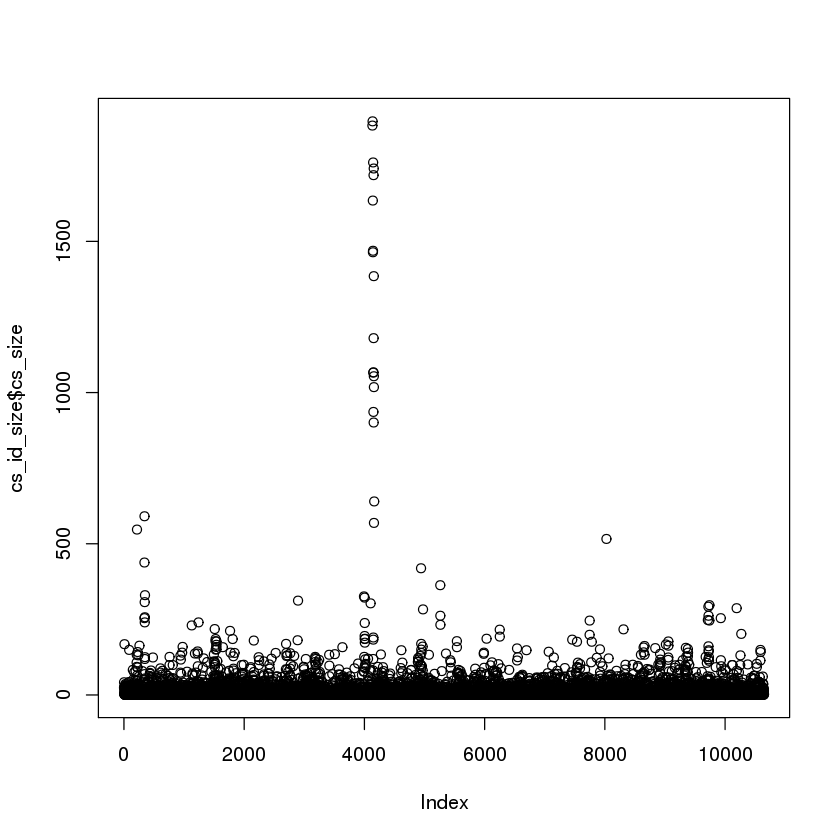

In [16]:
plot(cs_id_size$cs_size)

**How many genes with CS have exactly one CS?**

In [28]:
genes_with_cs <- unique(sorted_df$phenotype_id)
df <- data.frame("gene" = genes_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df[sorted_df$phenotype_id == df[i,1],]$cs_id))
}
head(df)

,gene,cs_count
,<fct>,<int>
1,ENSG00000166024,1
2,ENSG00000119943,1
3,ENSG00000205740,1
4,ENSG00000119946,1
5,ENSG00000014919,1
6,ENSG00000233690,1


In [29]:
summary(df$cs_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.396   2.000   8.000 

In [30]:
dim(df)

[1] 7626    2

In [31]:
sum(df$cs_count == 1)

[1] 5486

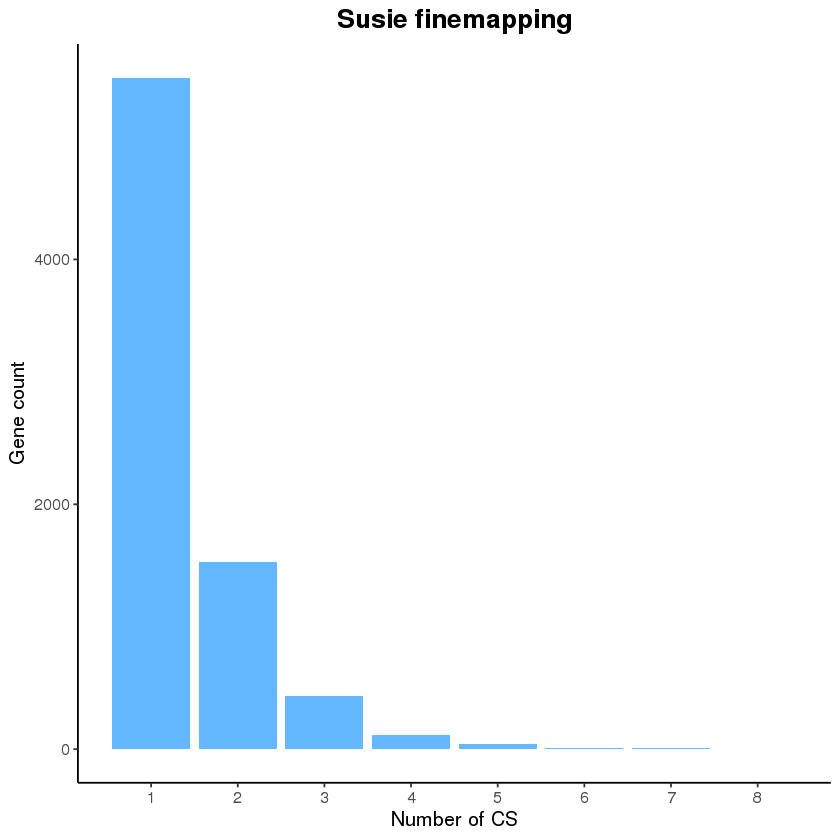

In [32]:
p <- ggplot(df, aes(x=cs_count)) +
  geom_bar(fill="steelblue1") +
  scale_x_continuous(breaks = seq(1,9,by=1)) +
  labs(x="Number of CS", y="Gene count") +
  ggtitle("Susie finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p

### 2. all credible sets (not filtered for purity)

In [34]:
cs <- fread("mixed_ciseqtl_90hcp_perm.cred.txt.gz", data.table = F)
dim(cs)

[1] 15254     9

In [14]:
head(cs)

,phenotype_id,cs_id,cs_index,finemapped_region,cs_log10bf,cs_avg_r2,cs_min_r2,cs_size,low_purity
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,ENSG00000270863,ENSG00000270863_L1,L1,chr12:10665656-12665656,19.564379,0.9242394,0.8048506,34,FALSE
2,ENSG00000270863,ENSG00000270863_L2,L2,chr12:10665656-12665656,4.263458,0.7465146,0.4323245,12,FALSE
3,ENSG00000247157,ENSG00000247157_L3,L3,chr12:10700963-12700963,1.675373,1.0000000,1.0000000,1,FALSE
4,ENSG00000247157,ENSG00000247157_L1,L1,chr12:10700963-12700963,30.826474,0.9786380,0.9477680,4,FALSE
5,ENSG00000247157,ENSG00000247157_L2,L2,chr12:10700963-12700963,36.138428,0.9771133,0.9339625,7,FALSE
6,ENSG00000070018,ENSG00000070018_L1,L1,chr12:11419977-13419977,2.720819,0.7406333,0.4075157,37,FALSE


In [15]:
length(unique(cs$phenotype_id))

[1] 10197

In [20]:
table(cs$low_purity)


FALSE  TRUE 
10647  4607 

In [35]:
head(cs %>% filter(low_purity))

,phenotype_id,cs_id,cs_index,finemapped_region,cs_log10bf,cs_avg_r2,cs_min_r2,cs_size,low_purity
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,ENSG00000111261,ENSG00000111261_L1,L1,chr12:11503175-13503175,4.07944167,0.726510897,1.744063e-01,11,TRUE
2,ENSG00000255670,ENSG00000255670_L2,L2,chr12:11638286-13638286,0.45976964,0.003582169,4.231532e-10,2859,TRUE
3,ENSG00000111269,ENSG00000111269_L1,L1,chr12:11764760-13764760,2.16559198,0.568307145,9.618169e-02,25,TRUE
4,ENSG00000275963,ENSG00000275963_L5,L5,chr12:11801872-13801872,0.05347751,0.003353675,1.313858e-09,5537,TRUE
5,ENSG00000183150,ENSG00000183150_L7,L7,chr12:11849140-13849140,0.01117094,0.003360231,1.960944e-10,5668,TRUE
6,ENSG00000178878,ENSG00000178878_L2,L2,chr12:11878850-13878850,1.01661800,0.034086444,1.156653e-06,30,TRUE


**See code for low purity definition:**
```{r}
dplyr::mutate(
        cs_avg_r2 = mean.abs.corr^2,
        cs_min_r2 = min.abs.corr^2,
        low_purity = min.abs.corr < 0.5
      )
```

In [36]:
max(cs %>% filter(low_purity) %>% select(cs_min_r2))

[1] 0.2498847

In [37]:
min(cs %>% filter(!low_purity) %>% select(cs_min_r2))

[1] 0.2500968

### 3. all tested variants (very big file)